# Batch effect removal for the entire rnaseq dataset
### Jam session started on 04-24-2018

Generate multiple datasets:
- source scaling and combat for `combined_rnaseq_data` and `combined_rnaseq_data_lincs1000`
- source scaling and combat for `combined_rnaseq_data` and `combined_rnaseq_data_lincs1000` from Apr2018

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import sys
from time import time
import numpy as np
import pandas as pd
from pprint import pprint

In [2]:
# utils_path = os.path.abspath(os.path.join('..', 'utils_py'))
utils_path = os.path.abspath(os.path.join('../../', 'utils_py'))
sys.path.append(utils_path)

# from pilot1_imports import *

In [3]:
utils_path = os.path.abspath(os.path.join('../../', 'utils'))
sys.path.append(utils_path)
from rna import CombinedRNASeqLINCS
from utils_ml import plot_pca

In [4]:
# ComBat imports
import patsy  # for combat
from combat import *

In [5]:
def scale_rnaseq(df, per_source=False):
    """ Scale df values and return updated df. """
    from sklearn.preprocessing import StandardScaler
    from pandas.api.types import is_string_dtype, is_numeric_dtype
    df = df.copy()

    if per_source:
        sources = df['Sample'].map(lambda x: x.split('.')[0].lower()).unique().tolist()
        for i, source in enumerate(sources):
            print('Scaling {}'.format(source))
            source_vec = df['Sample'].map(lambda x: x.split('.')[0].lower())
            source_idx_bool = source_vec.str.startswith(source)

            data_values = df.loc[source_idx_bool, df.columns[1:].values].values
            values_scaled = StandardScaler().fit_transform(data_values)
            df.loc[source_idx_bool, 1:] = values_scaled
    else:
        if is_numeric_dtype(df.iloc[:, 1:]):
            df.iloc[:, 1:] = StandardScaler().fit_transform(df.iloc[:, 1:])
        # data_values = df.iloc[:, 1:].values
        # values_scaled = StandardScaler().fit_transform(data_values)
        # df.iloc[:, 1:] = values_scaled

    return df

In [6]:
def ap_combat(rna, meta):
    """ ... """
    dat, pheno, _, _ = py_df_to_R_df(data = rna, meta = meta, to_scale=False,
                                     filename=None, to_save=False, var_thres=None)
    # dat.columns.name = None
    # pheno.index.name = pheno.columns.name
    # pheno.columns.name = None

    mod = patsy.dmatrix("~1", data=pheno, return_type="dataframe")
    ebat = combat(data = dat,
                  batch = pheno['source'],  # pheno['batch']
                  model = mod)

    df_rna_be = R_df_to_py_df(ebat)
    return df_rna_be

In [7]:
def py_df_to_R_df(data, meta, filename=None, to_save=False, to_scale=False, var_thres=None):
    """ Convert python dataframe to R dataframe (transpose). """
    data, meta = update_df_and_meta(data.copy(), meta.copy(), on='Sample')

    # Remove low var columns (this is required for SVA)
    if var_thres is not None:
        data, low_var_col_names = rmv_low_var_genes(data, var_thres=var_thres, per_source=True, verbose=True)

    # Scale dataset
    # todo: Scaling provides worse results in terms of kNN(??)
    # if to_scale:
    #     dat = scale_rnaseq(dat, per_source=False)

    # Transpose df for processing in R
    data_r = data.set_index('Sample', drop=True)
    data_r = data_r.T

    # This is required for R
    meta_r = meta.set_index('Sample', drop=True)
    del meta_r.index.name
    meta_r.columns.name = 'Sample'

    if to_save:
        print('Data shape to save:', data_r.shape)
        file_format = '.txt'
        foldername = 'save'
        verify_folder(foldername)

        if filename is not None:
            data_r.to_csv(os.path.join(foldername, filename + '_dat_R' + file_format), sep='\t')
            meta_r.to_csv(os.path.join(foldername, filename + '_pheno_R' + file_format), sep='\t')
        else:
            data_r.to_csv(os.path.join(foldername, 'dat_R' + file_format), sep='\t')
            meta_r.to_csv(os.path.join(foldername, 'pheno_R' + file_format), sep='\t')

    return data_r, meta_r, data, meta

In [8]:
def update_df_and_meta(df_rna, meta, on='Sample'):
    """ Update df_rna and metadata to match.
    TODO: move to the class dataset
    """
    df_rna = df_rna.copy()
    meta = meta.copy()
    df = pd.merge(meta, df_rna, how='inner', on=on).reset_index(drop=True)

    df_rna = df[['Sample'] + df_rna.columns[1:].tolist()]
    meta = df.drop(columns=df_rna.columns[1:].tolist())
    return df_rna, meta

In [9]:
def R_df_to_py_df(data):
    """ This is applied to the output of combat.py """
    return data.T.reset_index().rename(columns={'index': 'Sample'})

# Utils

In [10]:
def check_mapping_cells(df, cl_mapping):
    d1 = cl_mapping.merge(df, left_on='from_cell', right_on='Sample')
    d1 = d1.sort_values('from_cell')
    d1 = d1.drop(columns=['from_cell', 'to_cell'])
    
    d2 = cl_mapping.merge(df, left_on='to_cell', right_on='Sample')
    d2 = d2.sort_values('from_cell')
    d2 = d2.drop(columns=['from_cell', 'to_cell'])
    
    diff = (d1.iloc[:, 1:].values - d2.iloc[:, 1:].values).sum()
    return diff

# Load data

In [11]:
DATAPATH = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018/Apr2018'

OUTDIR = '.'

# RNA-Seq dataset
# DATASET = 'combined_rnaseq_data'
DATASET = 'combined_rnaseq_data_lincs1000'
# DATASET = 'combined_rnaseq_data_oncogenes'

# Metadata
# PDM_METADATA_FILENAME = 'comb_sample_metadata_march2018.txt'
PDM_METADATA_FILENAME = 'combined_metadata_2018May.txt'

In [12]:
datadir = Path('../../data/raw/')
outdir = Path('.')
dataname = 'combined_rnaseq_data_lincs1000'
metaname = 'combined_metadata_2018May.txt'

# DATAPATH = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
# OUTDIR = '.'
# DATASET = 'combined_rnaseq_data_lincs1000'
# PDM_METADATA_FILENAME = 'combined_metadata_2018May.txt'

In [13]:
lincs = CombinedRNASeqLINCS(datadir=datadir, cellmeta_fname=metaname,
                            rna_norm='raw', sources=['ccle', 'gdc', 'nci60', 'ncipdm'],
                            na_values=['na', '-', ''], verbose=True)


Dataset: combined_rnaseq_data_lincs1000
rna (13357, 943)
meta   (13357, 20)
GDC       11081
NCIPDM     1198
CCLE       1018
NCI60        60
Name: Sample, dtype: int64


In [14]:
rna, meta = lincs.get_rna(), lincs.get_meta()
print(rna.shape)
print(meta.shape)

(13357, 943)
(13357, 20)


In [8]:
# Load rnaseq
df_rna = load_combined_rnaseq(dataset=os.path.join(DATAPATH, DATASET), chunksize=2000, verbose=True)

Loading dataframe by chunks...
/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_rnaseq_data_oncogenes: (15196, 1942)
gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        670
gcsi        357
nci60        60
Name: Sample, dtype: int64


In [9]:
df_rna_org = df_rna.copy()

In [10]:
# Choose datasets to process

# datasets_to_keep = ['ccle', 'ctrp', 'gdsc', 'ncipdm', 'gcsi', 'nci60']
datasets_to_keep = ['ccle', 'gdc', 'nci60', 'ncipdm']
# datasets_to_keep = None
# use_metadata_file = False
use_metadata_file = True

# datasets_to_keep = ['ncipdm', 'nci60']
# use_metadata_file = True

In [11]:
# Get the metadata
if use_metadata_file:
    # Load metadata file
    meta = pd.read_csv(os.path.join(DATAPATH, PDM_METADATA_FILENAME), sep='\t')
    # meta = update_metadata_comb(meta)
    meta = update_metadata_comb_may2018(meta)
    meta = extract_specific_datasets(meta, datasets_to_keep = datasets_to_keep)
    df_rna, meta = update_df_and_meta(df_rna=df_rna, meta=meta, on='Sample')
else:
    # If not using metadata file then use the source as meta
    meta = extract_specific_datasets(df_rna, datasets_to_keep = datasets_to_keep)
    meta['source'] = meta['Sample'].map(lambda x: x.split('.')[0].lower())  # add `source` col
    meta = meta[['Sample', 'source']]  # keep only `Sample` and `source` cols
    df_rna, meta = update_df_and_meta(df_rna=df_rna, meta=meta, on='Sample')

In [12]:
print(df_rna.shape)
df_rna[:2]

(13357, 1942)


,Sample,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABI1,ABL1,...,ZNF451,ZNF521,ZNF586,ZNF589,ZNF638,ZNF703,ZNF750,ZNF814,ZRSR2,ZW10
0,CCLE.22RV1,8.31,7.17,4.12,5.64,6.04,3.94,2.08,5.86,5.24,...,3.90,0.03,4.19,3.88,5.38,1.08,0.23,2.57,3.42,5.37
1,CCLE.2313287,8.94,6.30,3.83,6.60,5.99,6.34,3.72,6.30,4.67,...,3.97,0.04,3.82,3.78,5.39,4.56,0.25,2.18,3.77,5.49


In [13]:
# Load the cell line mapping
cl_mapping = pd.read_csv(os.path.join(DATAPATH, 'cl_mapping'), sep='\t', header=None)
cl_mapping.rename(columns={0: 'from_cell', 1: 'to_cell'}, inplace=True)
print(cl_mapping.shape)
cl_mapping[:2]

(1841, 2)


,from_cell,to_cell
0,CCLE.22RV1,GDSC.22RV1
1,CCLE.2313287,GDSC.23132-87


# Raw data

Explained variance by PCA components [1, 2]: [0.37752, 0.12893]


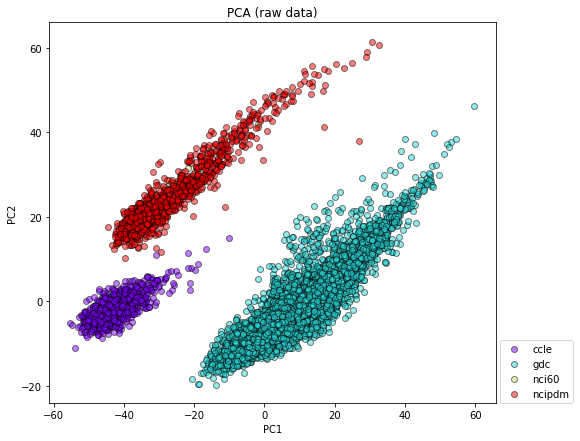

In [15]:
# New
plot_pca(rna.iloc[:, 1:], components = [1, 2], figsize=(8,7),
         color_vector = rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         scale=True, title='PCA (raw data)');

Explained variance by PCA components [1, 2]:  [0.37506, 0.11309]


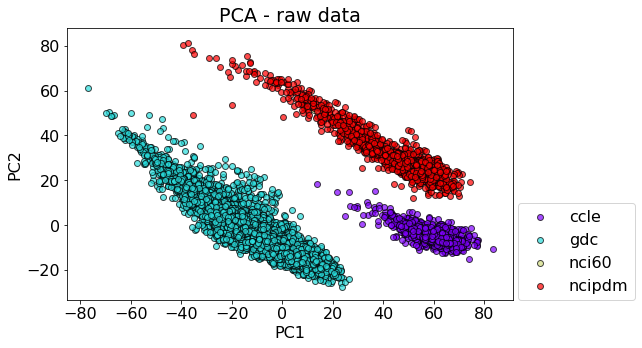

In [14]:
# Old
plot_pca(df_rna.iloc[:, 1:], components = [1, 2],
         color_vector = df_rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         to_scale=True, title='PCA - raw data');

# Per-source scaling

Scaling ccle
Scaling gdc
Scaling nci60
Scaling ncipdm
Explained variance by PCA components [1, 2]: [0.29724, 0.06456]


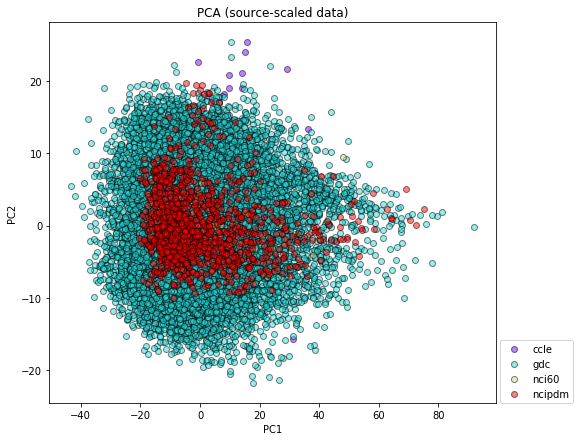

In [16]:
# New
rna_sc = scale_rnaseq(df=rna, per_source=True)

plot_pca(rna_sc.iloc[:, 1:], components = [1, 2], figsize=(8,7),
         color_vector = rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         scale=True, title='PCA (source-scaled data)');

In [15]:
# Old
df_rna_sc = scale_rnaseq(df=df_rna, per_source=True)

Scaling ccle
Scaling gdc
Scaling nci60
Scaling ncipdm


Explained variance by PCA components [1, 2]:  [0.28916, 0.06277]


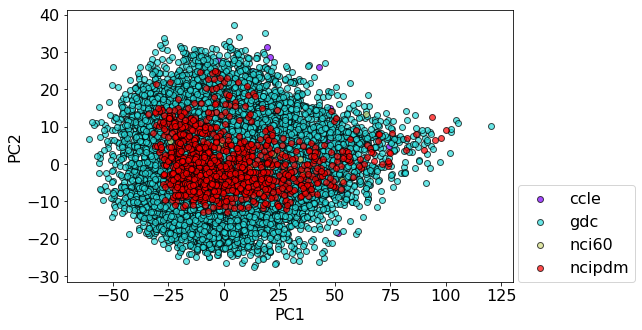

In [16]:
plot_pca(df_rna_sc.iloc[:, 1:],
         color_vector = df_rna_sc['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title=None);

In [17]:
df_rna_sc = copy_rna_profiles_to_cell_lines(df_rna_sc, cl_mapping)

In [18]:
check_mapping_cells(df_rna_sc, cl_mapping)

0.0

In [19]:
df_rna_sc = df_rna_sc.sort_values('Sample')

In [20]:
filename = DATASET + '_source_scale'
df_rna_sc.to_csv(os.path.join(OUTDIR, filename), sep='\t', float_format=np.float16, index=False)

#### Note that there are 2 extra gdsc cell lines added from cl_mapping (??)

In [21]:
df_rna_sc.Sample.map(lambda x: x.split('.')[0].lower()).value_counts()

gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        672
gcsi        357
nci60        60
Name: Sample, dtype: int64

In [22]:
df_rna_org.Sample.map(lambda x: x.split('.')[0].lower()).value_counts()

gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        670
gcsi        357
nci60        60
Name: Sample, dtype: int64

In [23]:
set(df_rna_sc['Sample'].tolist()) - set(df_rna_org['Sample'].tolist())

{'GDSC.KMH-2', 'GDSC.T-T'}

# Combat

found 4 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
Explained variance by PCA components [1, 2]: [0.29736, 0.06460]


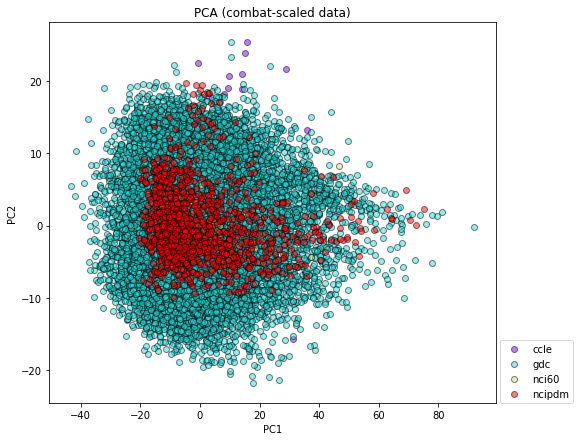

In [17]:
# New
rna_cmbt = ap_combat(rna, meta)

plot_pca(rna_cmbt.iloc[:, 1:], components = [1, 2], figsize=(8,7),
         color_vector = rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         scale=True, title='PCA (combat-scaled data)');

In [25]:
display(rna_sc.head())
print(rna_sc.mean(axis=0).mean())
print(rna_sc.mean(axis=1).mean())
print(rna_sc.var(axis=0).mean())
print(rna_sc.var(axis=1).mean())

,Sample,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,CCLE.22RV1,0.643460,1.665659,-0.003287,-1.612203,0.440622,-0.603358,-0.688464,-0.259270,0.177445,...,-1.105644,0.636475,0.150561,-0.280040,0.931946,0.295963,1.241200,1.413897,0.753615,0.892603
1,CCLE.2313287,1.464803,1.039212,-0.309370,0.023618,0.332630,1.231317,0.944933,-0.957579,0.930679,...,-0.572183,0.575540,0.609772,-0.104829,-0.055401,-0.619046,1.373060,0.961168,0.649255,1.093517
2,CCLE.253J,-0.308257,1.204825,-0.562680,-1.101008,-0.142532,0.917893,-0.419551,-0.749311,-0.822302,...,-1.105644,-0.874736,-1.015131,0.105425,-1.162833,-1.250087,-2.130655,-0.421490,-1.239657,-1.920201
3,CCLE.253JBV,-0.034476,0.830396,-0.077169,-0.249019,0.289433,0.650336,0.118275,-0.443035,-0.972949,...,-0.672207,-0.630992,-0.679553,-0.011383,-0.188827,-0.650598,-1.885771,-0.690680,-0.582190,-1.166772
4,CCLE.42MGBA,0.030710,1.341635,-1.090409,0.568892,-0.876873,0.497447,1.213846,0.488044,0.095274,...,0.778142,-1.569405,1.015998,0.666102,-0.735871,-0.240422,-0.303449,-0.727388,-1.103989,1.361403


3.9094235e-09
0.0
0.99919397
0.7340579


In [26]:
display(rna_cmbt.head())
print(rna_cmbt.mean(axis=0).mean())
print(rna_cmbt.mean(axis=1).mean())
print(rna_cmbt.var(axis=0).mean())
print(rna_cmbt.var(axis=1).mean())

,Sample,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,CCLE.22RV1,5.797465,4.391859,2.349457,3.382905,5.927901,3.683936,0.924674,2.403617,3.744548,...,1.420558,3.158631,1.917813,2.497956,3.147016,2.884360,2.976346,2.114080,2.120396,2.920563
1,CCLE.2313287,6.515861,3.786915,2.019671,4.846819,5.844720,5.459848,2.136946,1.829353,4.351104,...,1.910574,3.112777,2.175691,2.631460,2.342823,2.036390,3.054986,1.859844,2.043321,3.048745
2,CCLE.253J,4.965035,3.946843,1.746744,3.840379,5.478727,5.156463,1.124256,2.000624,2.939483,...,1.420558,2.021439,1.263199,2.791664,1.440822,1.451583,0.965411,1.083396,0.648260,1.126024
3,CCLE.253JBV,5.204501,3.585267,2.269854,4.602834,5.811448,4.897476,1.523418,2.252495,2.818172,...,1.818696,2.204858,1.451648,2.702662,2.234148,2.007150,1.111457,0.932229,1.133833,1.606704
4,CCLE.42MGBA,5.261517,4.078957,1.178147,5.334791,4.913100,4.749483,2.336527,3.018180,3.678378,...,3.150929,1.498698,2.403814,3.218875,1.788581,2.387274,2.055136,0.911615,0.748457,3.219654


3.6128409111071575
3.6128409111071575
1.1589845262251217
3.721747358363351


In [24]:
# Old
df_rna_be = ap_combat(df_rna, meta)

found 4 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


Explained variance by PCA components [1, 2]:  [0.28926, 0.06281]


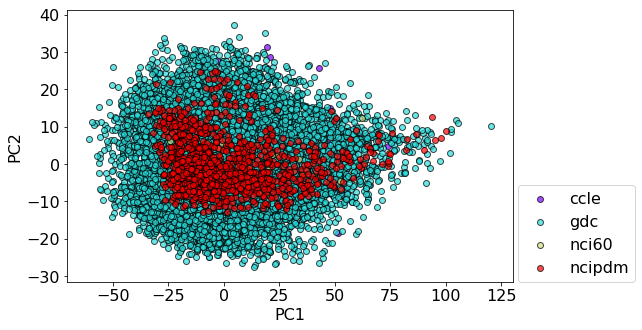

In [25]:
plot_pca(df_rna_be.iloc[:, 1:],
         color_vector = df_rna_be['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title=None);

In [26]:
df_rna_be = copy_rna_profiles_to_cell_lines(df_rna_be, cl_mapping)

In [27]:
check_mapping_cells(df_rna_be, cl_mapping)

0.0

In [28]:
df_rna_be = df_rna_be.sort_values('Sample')

In [29]:
filename = DATASET + '_combat'
df_rna_be.to_csv(os.path.join(OUTDIR, filename), sep='\t', float_format=np.float16, index=False)

# Load and check the stored data

In [30]:
# DATAPATH = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018/Apr2018'

# RNA-Seq dataset
# DATASET = 'combined_rnaseq_data_combat'
# DATASET = 'combined_rnaseq_data__scale_per_source'

DATASET = 'combined_rnaseq_data_lincs1000_combat'
# DATASET = 'combined_rnaseq_data_lincs1000_scale_per_source'

In [31]:
df_rna = load_combined_rnaseq(dataset=os.path.join(DATAPATH, DATASET), chunksize=2000, verbose=True)

Loading dataframe by chunks...
/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_rnaseq_data_lincs1000_combat: (15198, 943)
gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        672
gcsi        357
nci60        60
Name: Sample, dtype: int64


Explained variance by PCA components [1, 2]:  [0.27019, 0.06032]


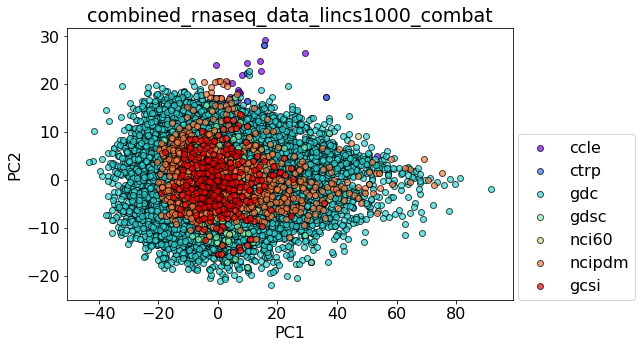

In [32]:
plot_pca(df_rna.iloc[:, 1:],
         color_vector = df_rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title=DATASET);